# Prepare dataset

In [5]:
import torch
import random
import pandas as pd
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
random.seed(0)

class UserItemRatingDataset(Dataset):
   #转换 PyTorch 数据集
    def __init__(self, user_tensor, item_tensor, target_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)

class SampleGenerator(object):
    #构建 NCF 数据集
    def __init__(self, ratings):
        assert 'userId' in ratings.columns
        assert 'itemId' in ratings.columns
        assert 'rating' in ratings.columns

        self.ratings = ratings
        self.preprocess_ratings = self._binarize(ratings)
        self.user_pool = set(self.ratings['userId'].unique())
        self.item_pool = set(self.ratings['itemId'].unique())
        self.negatives = self._sample_negative(ratings)
        self.train_ratings, self.test_ratings = self._split_loo(self.preprocess_ratings)

    def _normalize(self, ratings):
        ratings = deepcopy(ratings)
        max_rating = ratings.rating.max()
        ratings['rating'] = ratings.rating * 1.0 / max_rating
        return ratings

    def _binarize(self, ratings):
        ratings = deepcopy(ratings)
        ratings['rating'] = ratings['rating'].apply(lambda x: 1.0 if x > 0 else 0.0)
        return ratings

    def _split_loo(self, ratings):
        ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
        test = ratings[ratings['rank_latest'] == 1]
        train = ratings[ratings['rank_latest'] > 1]
        assert train['userId'].nunique() == test['userId'].nunique()
        return train[['userId', 'itemId', 'rating']], test[['userId', 'itemId', 'rating']]

    def _sample_negative(self, ratings):
        interact_status = ratings.groupby('userId')['itemId'].apply(set).reset_index().rename(columns={'itemId': 'interacted_items'})
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, min(99, len(x))))
        return interact_status[['userId', 'negative_items', 'negative_samples']]

    def instance_a_train_loader(self, num_negatives, batch_size):
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['userId', 'negative_items']], on='userId')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))
        for row in train_ratings.itertuples():
            users.append(int(row.userId))
            items.append(int(row.itemId))
            ratings.append(float(row.rating))
            for i in range(len(row.negatives)):
                users.append(int(row.userId))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  
        dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(users),
                                        item_tensor=torch.LongTensor(items),
                                        target_tensor=torch.FloatTensor(ratings))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    @property
    def evaluate_data(self):
        test_ratings = pd.merge(self.test_ratings, self.negatives[['userId', 'negative_samples']], on='userId')
        test_users, test_items, negative_users, negative_items = [], [], [], []
        for row in test_ratings.itertuples():
            test_users.append(int(row.userId))
            test_items.append(int(row.itemId))
            for i in range(len(row.negative_samples)):
                negative_users.append(int(row.userId))
                negative_items.append(int(row.negative_samples[i]))
        return [torch.LongTensor(test_users), torch.LongTensor(test_items), torch.LongTensor(negative_users),
                torch.LongTensor(negative_items)]

# Functions for model training

In [6]:
def save_checkpoint(model, model_dir):
    #将模型的状态保存到指定路径
    torch.save(model.state_dict(), model_dir)

def resume_checkpoint(model, model_dir, device='cpu'):
    #从指定路径加载模型的状态
    state_dict = torch.load(model_dir, map_location=device)
    model.load_state_dict(state_dict)

def use_cuda(enabled, device_id=0):
    if enabled:
        assert torch.cuda.is_available()
        torch.cuda.set_device(device_id)

def use_optimizer(network, params):
    #根据提供的参数返回相应的优化器
    if params['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(network.parameters(),
                                    lr=params.get('sgd_lr', 0.01),
                                    momentum=params.get('sgd_momentum', 0.9),
                                    weight_decay=params.get('l2_regularization', 0))
    elif params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(network.parameters(),
                                     lr=params.get('adam_lr', 0.001),
                                     weight_decay=params.get('l2_regularization', 0))
    elif params['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(network.parameters(),
                                        lr=params.get('rmsprop_lr', 0.01),
                                        alpha=params.get('rmsprop_alpha', 0.99),
                                        momentum=params.get('rmsprop_momentum', 0.9))
    return optimizer

if __name__ == "__main__":
    class SimpleModel(torch.nn.Module):
        def __init__(self):
            super(SimpleModel, self).__init__()
            self.linear = torch.nn.Linear(10, 1)

        def forward(self, x):
            return self.linear(x)

    model = SimpleModel()
    save_checkpoint(model, "model.pth")
    resume_checkpoint(model, "model.pth", device='cpu')

# Evaluation metrics 

In [8]:
import math
class MetronAtK(object):
    #评估推荐系统的性能指标
    def __init__(self, top_k):
        self._top_k = top_k
        self._subjects = None 

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, top_k):
        self._top_k = top_k

    @property
    def subjects(self):
        return self._subjects

    @subjects.setter
    def subjects(self, subjects):
        #设置评估的对象
        assert isinstance(subjects, list)
        test_users, test_items, test_scores = subjects[0], subjects[1], subjects[2]
        neg_users, neg_items, neg_scores = subjects[3], subjects[4], subjects[5]
        test = pd.DataFrame({'user': test_users,
                             'test_item': test_items,
                             'test_score': test_scores})
        full = pd.DataFrame({'user': neg_users + test_users,
                             'item': neg_items + test_items,
                             'score': neg_scores + test_scores})
        full = pd.merge(full, test, on=['user'], how='left')
        full['rank'] = full.groupby('user')['score'].rank(method='first', ascending=False)
        full.sort_values(['user', 'rank'], inplace=True)
        self._subjects = full

    def cal_hit_ratio(self):
        #计算命中率
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank'] <= top_k]
        test_in_top_k = top_k[top_k['test_item'] == top_k['item']]  
        return len(test_in_top_k) * 1.0 / full['user'].nunique()

    def cal_ndcg(self):
        #归一化
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank'] <= top_k]
        test_in_top_k = top_k[top_k['test_item'] == top_k['item']]
        test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x)) 
        return test_in_top_k['ndcg'].sum() * 1.0 / full['user'].nunique()

# Engine

In [10]:
from tensorboardX import SummaryWriter
from torch import nn
class Engine(object):
    def __init__(self, config):
        self.config = config  # model configuration
        self._metron = MetronAtK(top_k=10)
        self._writer = SummaryWriter(log_dir='runs/{}'.format(config['alias']))  # tensorboard writer
        self._writer.add_text('config', str(config), 0)
        self.opt = use_optimizer(self.model, config)
        # explicit feedback
        # self.crit = torch.nn.MSELoss()
        # implicit feedback
        self.crit = torch.nn.BCELoss()

    def train_single_batch(self, users, items, ratings):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        if self.config['use_cuda'] is True:
            users, items, ratings = users.cuda(), items.cuda(), ratings.cuda()
        self.opt.zero_grad()
        ratings_pred = self.model(users, items)
        loss = self.crit(ratings_pred.view(-1), ratings)
        loss.backward()
        self.opt.step()
        return loss.item()

    def train_an_epoch(self, train_loader, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.train()
        total_loss = 0
        for batch_id, batch in enumerate(train_loader):
            assert isinstance(batch[0], torch.Tensor)
            user, item, rating = batch[0], batch[1], batch[2]
            rating = rating.float()
            loss = self.train_single_batch(user, item, rating)
            total_loss += loss
        self._writer.add_scalar('model/loss', total_loss, epoch_id)

    def evaluate(self, evaluate_data, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.eval()
        with torch.no_grad():
            test_users, test_items = evaluate_data[0], evaluate_data[1]
            negative_users, negative_items = evaluate_data[2], evaluate_data[3]
            if self.config['use_cuda'] is True:
                test_users = test_users.cuda()
                test_items = test_items.cuda()
                negative_users = negative_users.cuda()
                negative_items = negative_items.cuda()
            test_scores = self.model(test_users, test_items)
            negative_scores = self.model(negative_users, negative_items)
            if self.config['use_cuda'] is True:
                test_users = test_users.cpu()
                test_items = test_items.cpu()
                test_scores = test_scores.cpu()
                negative_users = negative_users.cpu()
                negative_items = negative_items.cpu()
                negative_scores = negative_scores.cpu()
            self._metron.subjects = [test_users.numpy().tolist(),
                                     test_items.numpy().tolist(),
                                     test_scores.numpy().tolist(),
                                     negative_users.numpy().tolist(),
                                     negative_items.numpy().tolist(),
                                     negative_scores.numpy().tolist()]
        hit_ratio, ndcg = self._metron.cal_hit_ratio(), self._metron.cal_ndcg()
        self._writer.add_scalar('performance/HR', hit_ratio, epoch_id)
        self._writer.add_scalar('performance/NDCG', ndcg, epoch_id)
        return hit_ratio, ndcg

    def save(self, alias, epoch_id, hit_ratio, ndcg):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        model_dir = self.config['model_dir'].format(alias, epoch_id, hit_ratio, ndcg)
        save_checkpoint(self.model, model_dir)


# GMF

In [11]:
class GMF(nn.Module):
    def __init__(self, config):
        super(GMF, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.affine_output = nn.Linear(in_features=self.latent_dim, out_features=1)
        self.logistic = nn.Sigmoid()

        if config.get('weight_init_gaussian', False):
            for module in self.modules():
                if isinstance(module, (nn.Embedding, nn.Linear)):
                    nn.init.normal_(module.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

class GMFEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = GMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(GMFEngine, self).__init__(config)


# MLP

In [18]:
class MLP(nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = nn.ModuleList()
        input_size = self.latent_dim * 2  # 因为我们会将用户和物品的嵌入向量拼接
        for idx, layer_size in enumerate(config['layers']):
            self.fc_layers.append(nn.Linear(input_size, layer_size))
            input_size = layer_size

        self.affine_output = nn.Linear(in_features=config['layers'][-1], out_features=1)
        self.logistic = nn.Sigmoid()

        if config.get('weight_init_gaussian', False):
            for module in self.modules():
                if isinstance(module, (nn.Embedding, nn.Linear)):
                    nn.init.normal_(module.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # 拼接用户和物品的嵌入向量

        for layer in self.fc_layers:
            vector = layer(vector)
            vector = nn.ReLU()(vector)

        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def load_pretrain_weights(self):
        config = self.config
        gmf_model = GMF(config)  # GMF模型需要在你的代码中定义
        if config['use_cuda']:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'])  # 需要实现resume_checkpoint函数
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data

class MLPEngine(Engine):
    def __init__(self, config):
        self.model = MLP(config)
        if config['use_cuda']:
            use_cuda(True, config['device_id'])  # 需要实现use_cuda函数
            self.model.cuda()
        super(MLPEngine, self).__init__(config)
        print(self.model)

        if config.get('pretrain', False):
            self.model.load_pretrain_weights()

# NeuMF

In [13]:
class NeuMF(nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)
        self.logistic = nn.Sigmoid()

        # Initialize model parameters with a Gaussian distribution (with a mean of 0 and standard deviation of 0.01)
        if config.get('weight_init_gaussian', False):
            for sm in self.modules():
                if isinstance(sm, (nn.Embedding, nn.Linear)):
                    nn.init.normal_(sm.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained MLP model & GMF model"""
        config = self.config
        config['latent_dim'] = config['latent_dim_mlp']
        mlp_model = MLP(config)
        if config['use_cuda'] is True:
            mlp_model.cuda()
        resume_checkpoint(mlp_model, model_dir=config['pretrain_mlp'])

        self.embedding_user_mlp.weight.data = mlp_model.embedding_user.weight.data
        self.embedding_item_mlp.weight.data = mlp_model.embedding_item.weight.data
        for idx in range(len(self.fc_layers)):
            self.fc_layers[idx].weight.data = mlp_model.fc_layers[idx].weight.data

        config['latent_dim'] = config['latent_dim_mf']
        gmf_model = GMF(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'])
        self.embedding_user_mf.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item_mf.weight.data = gmf_model.embedding_item.weight.data

        self.affine_output.weight.data = 0.5 * torch.cat([mlp_model.affine_output.weight.data, gmf_model.affine_output.weight.data], dim=-1)
        self.affine_output.bias.data = 0.5 * (mlp_model.affine_output.bias.data + gmf_model.affine_output.bias.data)


class NeuMFEngine(Engine):
    """Engine for training & evaluating NeuMF model"""
    def __init__(self, config):
        self.model = NeuMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(NeuMFEngine, self).__init__(config)
        print(self.model)

        if config.get('pretrain', False):
            self.model.load_pretrain_weights()

# 三种模型比较

In [14]:
import os
import matplotlib.pyplot as plt
gmf_config = {'alias': 'gmf_factor8neg4-implict',
              'num_epoch': 80,
              'batch_size': 1024,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0,
              'weight_init_gaussian': True,
              'use_cuda': torch.cuda.is_available(),
              'device_id': 0,
              'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

mlp_config = {'alias': 'mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001',
              'num_epoch': 80,
              'batch_size': 256,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': 6040,
              'num_items': 3706,
              'latent_dim': 8,
              'num_negative': 4,
              'layers': [16, 64, 32, 16, 8],#使用5层隐藏层
              'l2_regularization': 0.0000001,
              'weight_init_gaussian': True,
              'use_cuda': torch.cuda.is_available(),
              'device_id': 0,
              'pretrain': False,
              'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
              'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}

neumf_config = {'alias': 'neumf_factor8neg4',
                'num_epoch': 80,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16, 64, 32, 16, 8],#使用5层隐藏层
                'l2_regularization': 0.0000001,
                'weight_init_gaussian': True,
                'use_cuda': torch.cuda.is_available(),
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
                'pretrain_mlp': 'checkpoints/{}'.format('mlp_factor8neg4_Epoch100_HR0.5606_NDCG0.2463.model'),
                'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}
ml1m_dir = 'NFS/src/data/ml-1m/ratings.dat'
ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'], engine='python')
user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')
item_id = ml1m_rating[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')
ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))
sample_generator = SampleGenerator(ratings=ml1m_rating)
evaluate_data = sample_generator.evaluate_data
# 创建保存目录
if not os.path.exists('results'):
    os.makedirs('results')
def train_and_evaluate_model(config, engine_class, model_name):
    engine = engine_class(config)
    hr_list, ndcg_list = [], []
    
    for epoch in range(config['num_epoch']):
        print('Epoch {} starts !'.format(epoch))
        print('-' * 80)
        train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
        engine.train_an_epoch(train_loader, epoch_id=epoch)
        hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
        hr_list.append(hit_ratio)
        ndcg_list.append(ndcg)
        engine.save(config['alias'], epoch, hit_ratio, ndcg)
    np.save(f'results/{model_name}_hr.npy', np.array(hr_list))
    np.save(f'results/{model_name}_ndcg.npy', np.array(ndcg_list))
    plt.figure()
    plt.plot(range(config['num_epoch']), hr_list, label='HR@10')
    plt.plot(range(config['num_epoch']), ndcg_list, label='NDCG@10')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.title(f'{model_name} Evaluation Metrics')
    plt.savefig(f'results/{model_name}_metrics.png')
    plt.show()

Range of userId is [0, 6039]
Range of itemId is [0, 3705]


/tmp/ipykernel_37/2819944936.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, min(99, len(x))))


In [ ]:
# 训练并评估 GMF 模型
train_and_evaluate_model(gmf_config, GMFEngine, 'GMF')

Epoch 0 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))
/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 1 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 2 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 3 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 4 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 5 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 6 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 7 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 8 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 9 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 10 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 11 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 12 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 13 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 14 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 15 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 16 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 17 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 18 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 19 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 20 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 21 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 22 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 23 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 24 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 25 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 26 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 27 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 28 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 29 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 30 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 31 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 32 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 33 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 34 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 35 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 36 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 37 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 38 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 39 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 40 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 41 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 42 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 43 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 44 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 45 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 46 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 47 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 48 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_502/36738621.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_502/565110687.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 49 starts !
--------------------------------------------------------------------------------


In [ ]:
# 训练并评估 MLP 模型
train_and_evaluate_model(mlp_config, MLPEngine, 'MLP')

In [ ]:
# 训练并评估 NeuMF 模型
train_and_evaluate_model(neumf_config, NeuMFEngine, 'NeuMF')

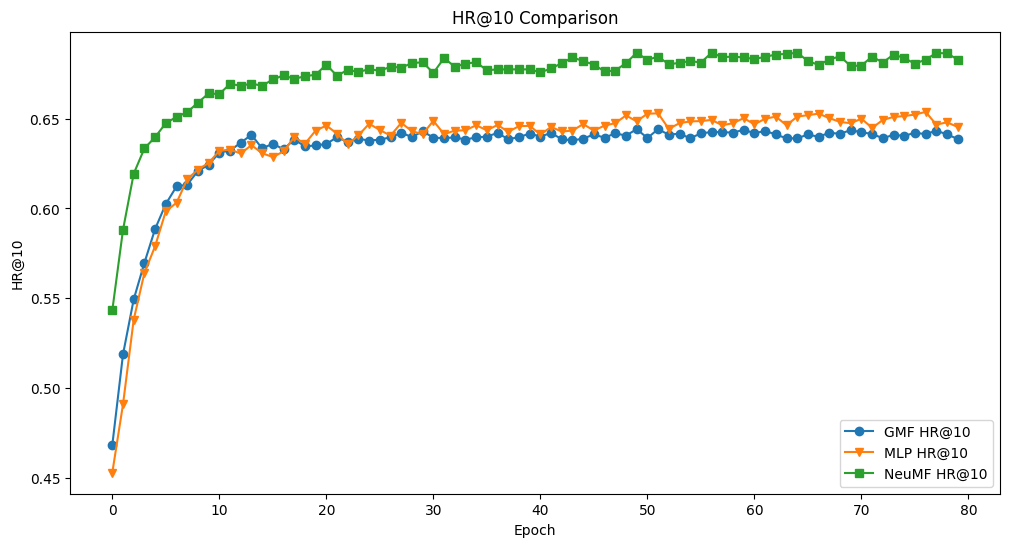

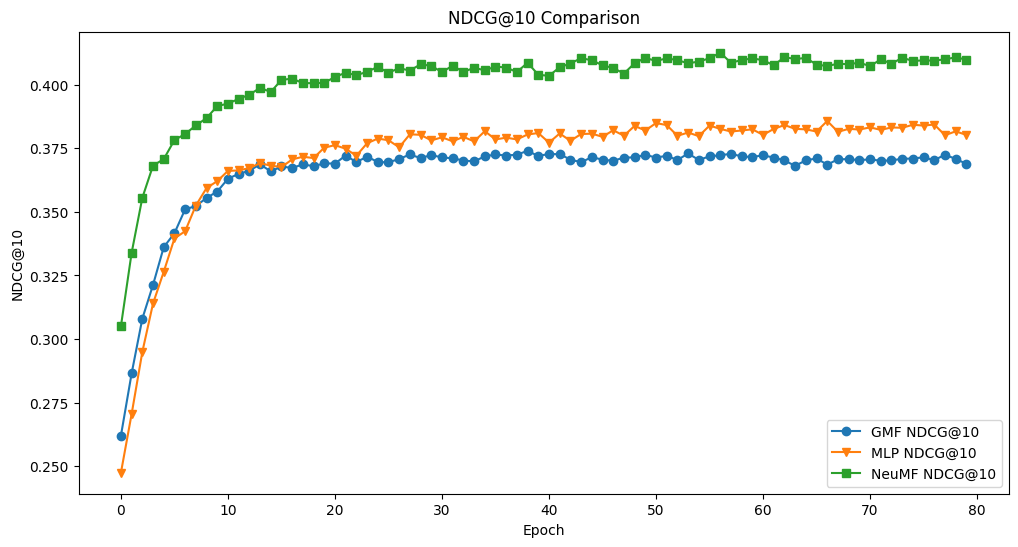

In [15]:
# 读取保存的评估指标数据
gmf_hr = np.load('results/GMF_hr.npy')
gmf_ndcg = np.load('results/GMF_ndcg.npy')

mlp_hr = np.load('results/MLP_hr.npy')
mlp_ndcg = np.load('results/MLP_ndcg.npy')

neumf_hr = np.load('results/NeuMF_hr.npy')
neumf_ndcg = np.load('results/NeuMF_ndcg.npy')

# 绘制 HR@10 对比图
plt.figure(figsize=(12, 6))
plt.plot(range(gmf_config['num_epoch']), gmf_hr, label='GMF HR@10', marker='o')
plt.plot(range(mlp_config['num_epoch']), mlp_hr, label='MLP HR@10', marker='v')
plt.plot(range(neumf_config['num_epoch']), neumf_hr, label='NeuMF HR@10', marker='s')
plt.xlabel('Epoch')
plt.ylabel('HR@10')
plt.legend()
plt.title('HR@10 Comparison')
plt.savefig('results/HR_comparison.png')
plt.show()

# 绘制 NDCG@10 对比图
plt.figure(figsize=(12, 6))
plt.plot(range(gmf_config['num_epoch']), gmf_ndcg, label='GMF NDCG@10', marker='o')
plt.plot(range(mlp_config['num_epoch']), mlp_ndcg, label='MLP NDCG@10', marker='v')
plt.plot(range(neumf_config['num_epoch']), neumf_ndcg, label='NeuMF NDCG@10', marker='s')
plt.xlabel('Epoch')
plt.ylabel('NDCG@10')
plt.legend()
plt.title('NDCG@10 Comparison')
plt.savefig('results/NDCG_comparison.png')
plt.show()


# MLP不同层数比较

MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))
/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 1 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 2 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 3 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 4 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 5 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 6 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 7 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 8 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 9 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 10 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 11 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 12 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 13 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 15 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 16 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 17 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 18 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 19 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 20 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 21 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 22 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 23 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 24 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 25 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 26 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 27 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 28 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 29 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 30 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 31 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 32 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 33 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 34 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 35 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 36 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 37 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 38 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 39 for mlp_layer_4 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1


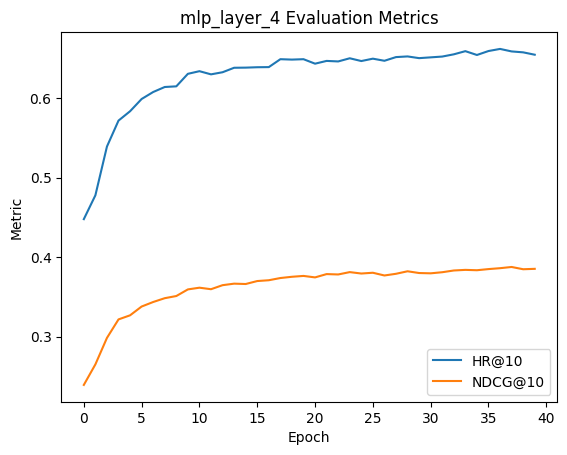

MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))
/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 1 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 2 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 3 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 4 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 5 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 6 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 7 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 8 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 9 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 10 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 11 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 12 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 13 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 14 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 15 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 16 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 17 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 18 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 19 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 20 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 21 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 22 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 23 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 24 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 25 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 26 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 27 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 28 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 29 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 30 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 31 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 32 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 33 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 34 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 35 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 36 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 37 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 38 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 39 for mlp_layer_3 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1


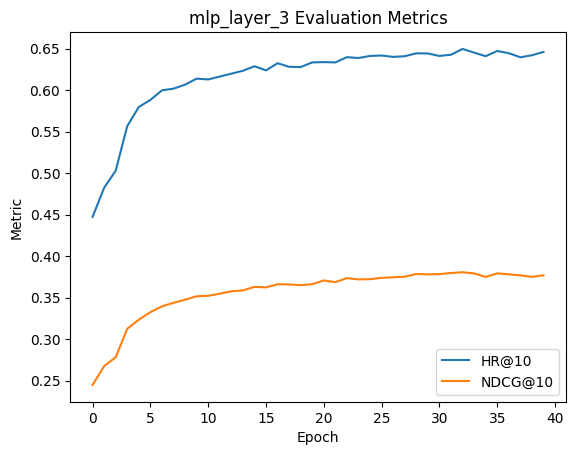

MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))
/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 1 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 2 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 3 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 4 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 5 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 6 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 7 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 8 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 9 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 10 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 11 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 12 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 13 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 14 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 15 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 16 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 17 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 18 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 19 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 20 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 21 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 22 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 23 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 24 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 25 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 26 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 27 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 28 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 29 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 30 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 31 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 32 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 33 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 34 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 35 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 36 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 37 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 38 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_37/2819944936.py:63: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, min(num_negatives, len(x))))


Epoch 39 for mlp_layer_2 starts!
--------------------------------------------------------------------------------


/tmp/ipykernel_37/3216382690.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1


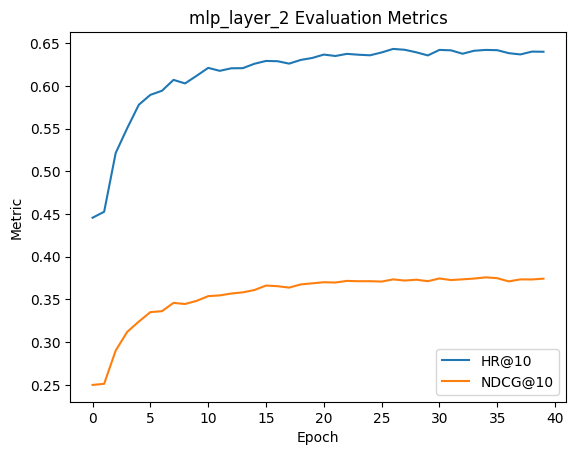

In [20]:
def train_and_evaluate_model(config, model_name):
    engine = MLPEngine(config)
    hr_list, ndcg_list = [], []  # 修改为空列表

    for epoch in range(config['num_epoch']):
        print(f'Epoch {epoch} for {model_name} starts!')
        print('-' * 80)
        train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])  # 需要实现sample_generator函数
        engine.train_an_epoch(train_loader, epoch_id=epoch)  # 需要在Engine类中实现train_an_epoch函数
        hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)  # 需要在Engine类中实现evaluate函数
        hr_list.append(hit_ratio)
        ndcg_list.append(ndcg)
        engine.save(config['alias'], epoch, hit_ratio, ndcg)  # 需要在Engine类中实现save函数
    
    np.save(f'results/{model_name}_hr.npy', np.array(hr_list))
    np.save(f'results/{model_name}_ndcg.npy', np.array(ndcg_list))

    plt.figure()
    plt.plot(range(config['num_epoch']), hr_list, label='HR@10')
    plt.plot(range(config['num_epoch']), ndcg_list, label='NDCG@10')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.title(f'{model_name} Evaluation Metrics')
    plt.savefig(f'results/{model_name}_metrics.png')
    plt.show()

# 不同层数的配置
mlp_configs = [
    {'alias': 'mlp_layer_5', 'num_epoch': 40, 'batch_size': 256, 'optimizer': 'adam', 'adam_lr': 1e-3,
     'num_users': 6040, 'num_items': 3706, 'latent_dim': 8, 'num_negative': 4, 'layers': [16, 64, 32, 16, 8],
     'l2_regularization': 0.0000001, 'weight_init_gaussian': True, 'use_cuda': torch.cuda.is_available(),
     'device_id': 0, 'pretrain': False, 'pretrain_mf': 'checkpoints/gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model',
     'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'},

    {'alias': 'mlp_layer_4', 'num_epoch': 40, 'batch_size': 256, 'optimizer': 'adam', 'adam_lr': 1e-3,
     'num_users': 6040, 'num_items': 3706, 'latent_dim': 8, 'num_negative': 4, 'layers': [64, 32, 16, 8],
     'l2_regularization': 0.0000001, 'weight_init_gaussian': True, 'use_cuda': torch.cuda.is_available(),
     'device_id': 0, 'pretrain': False, 'pretrain_mf': 'checkpoints/gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model',
     'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'},

    {'alias': 'mlp_layer_3', 'num_epoch': 40, 'batch_size': 256, 'optimizer': 'adam', 'adam_lr': 1e-3,
     'num_users': 6040, 'num_items': 3706, 'latent_dim': 8, 'num_negative': 4, 'layers': [32, 16, 8],
     'l2_regularization': 0.0000001, 'weight_init_gaussian': True, 'use_cuda': torch.cuda.is_available(),
     'device_id': 0, 'pretrain': False, 'pretrain_mf': 'checkpoints/gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model',
     'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'},

    {'alias': 'mlp_layer_2', 'num_epoch': 40, 'batch_size': 256, 'optimizer': 'adam', 'adam_lr': 1e-3,
     'num_users': 6040, 'num_items': 3706, 'latent_dim': 8, 'num_negative': 4, 'layers': [32, 16],
     'l2_regularization': 0.0000001, 'weight_init_gaussian': True, 'use_cuda': torch.cuda.is_available(),
     'device_id': 0, 'pretrain': False, 'pretrain_mf': 'checkpoints/gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model',
     'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'}
]

# 训练和评估不同层数的 MLP 模型
for config in mlp_configs:
    train_and_evaluate_model(config, config['alias'])

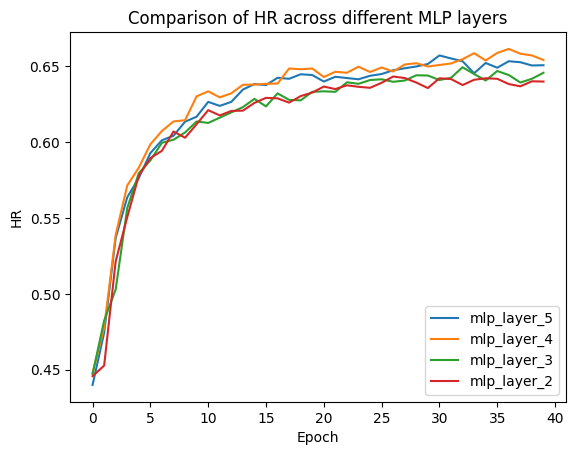

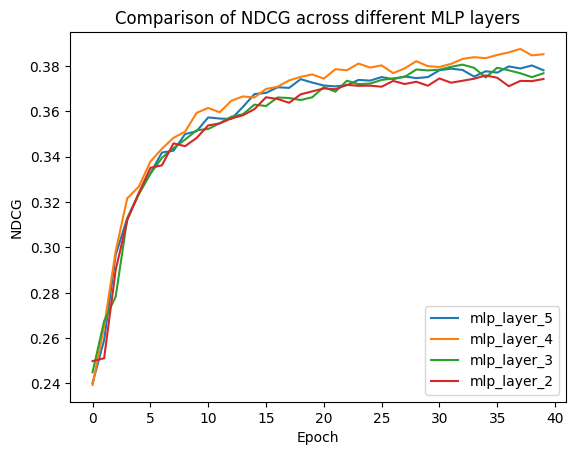

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# 加载保存的HR和NDCG结果并绘图
def plot_results(configs, metric):
    plt.figure()
    for config in configs:
        alias = config['alias']
        results = np.load(f'results/{alias}_{metric}.npy')
        plt.plot(range(config['num_epoch']), results, label=alias)
    
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.title(f'Comparison of {metric.upper()} across different MLP layers')
    plt.savefig(f'results/comparison_{metric}.png')
    plt.show()

# 绘制HR@10和NDCG@10的对比图
plot_results(mlp_configs, 'hr')
plot_results(mlp_configs, 'ndcg')
